# Detecting arrythmia using Deep Leaning

## Loading modules

In [1]:
import pandas as pd
import numpy as np
import wfdb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense, Dropout, TimeDistributed
from keras.optimizers import Adam

In [3]:
import matplotlib.pyplot as plt

## Download Dataset

In [5]:
import wget
import zipfile

database_filename = "mit-bih-arrhythmia-database-1.0.0.zip"
database_path = Path(database_filename)

if not database_path.exists():
    url = f'https://storage.googleapis.com/mitdb-1.0.0.physionet.org/{database_filename}'
    wget.download(url)
    with zipfile.ZipFile(database_filename, 'r') as zip_ref:
        zip_ref.extractall(".")

100% [........................................................................] 77030320 / 77030320

## Loading data

Loading list of records available, from dataset available [here](https://physionet.org/content/mitdb/1.0.0/)

In [6]:
records = np.loadtxt("mit-bih-arrhythmia-database-1.0.0/RECORDS", dtype=int)

Defining invalid beats as well as abnormal beats, according to [Physiobank](https://archive.physionet.org/physiobank/annotations.shtml)

In [7]:
invalid_beat = [
    "[", "!", "]", "x", "(", ")", "p", "t", 
    "u", "`", "'", "^", "|", "~", "+", "s", 
    "T", "*", "D", "=", '"', "@"
]

abnormal_beats = [
    "L", "R", "B", "A", "a", "J", "S", "V", 
    "r", "F", "e", "j", "n", "E", "/", "f", "Q", "?"
]

## Processing dataset

This function classify a beat according to its symbol and the list provided above.

In [8]:
def classify_beat(symbol):
    if symbol in abnormal_beats:
        return 1
    elif symbol == "N" or symbol == ".":
        return 0    

Given a signal, the beat location, and the window to be used as a sequence, this function gets the sequence. It will return an empty array in case of an invalid beat or empty sequence.

In [9]:
def get_sequence(signal, beat_loc, window_sec, fs):
    window_one_side = window_sec * fs
    beat_start = beat_loc - window_one_side
    beat_end = beat_loc + window_one_side
    if beat_end < signal.shape[0]:
        sequence = signal[beat_start:beat_end, 0]
        return sequence.reshape(1, -1, 1)
    else:
        return np.array([])

The code below will build a list of labels and sequences as well as map the sequences for each patient. The percentage calculated represents the ratio of abnormal beats in each patient data.

In [10]:
all_sequences = []
all_labels = []
window_sec = 3
subject_map = []
for subject in records:
    record = wfdb.rdrecord(f'mit-bih-arrhythmia-database-1.0.0/{subject}')
    annotation = wfdb.rdann(f'mit-bih-arrhythmia-database-1.0.0/{subject}', 'atr')
    atr_symbol = annotation.symbol
    atr_sample = annotation.sample
    fs = record.fs
    scaler = StandardScaler()
    signal = scaler.fit_transform(record.p_signal)
    subject_labels = []
    for i, i_sample in enumerate(atr_sample):
        label = classify_beat(atr_symbol[i])
        sequence = get_sequence(signal, i_sample, window_sec, fs)
        if label is not None and sequence.size > 0:
            all_sequences.append(sequence)
            subject_labels.append(label)

    normal_percentage = sum(subject_labels) / len(subject_labels)
    subject_map.append({
        "subject": subject,
        "percentage": normal_percentage,
        "num_seq": len(subject_labels),
        "start": len(all_labels),
        "end": len(all_labels)+len(subject_labels)
    })
    all_labels.extend(subject_labels)

Creating bins to be used to stratify the train and validation split. 

In [11]:
subject_map = pd.DataFrame(subject_map)

The code presented will create class in each patient is segmented.

In [12]:
bins = [0, 0.2, 0.6, 1.0]
subject_map["bin"] = pd.cut(subject_map['percentage'], bins=bins, labels=False, include_lowest=True)

Now, the dataset is split into train and validation, stratifying by the bin defined above.

In [13]:
train, validation = train_test_split(subject_map, test_size=0.25, stratify=subject_map["bin"], random_state=42)

This function build a dataset based on the map for each split.

In [14]:
def build_dataset(df, all_sequences, all_labels):
    sequences = []
    labels = []
    for i, row in df.iterrows():
        start = int(row["start"])
        end = int(row["end"])
        sequences.extend(all_sequences[start:end])
        labels.extend(all_labels[start:end])
        
    return np.vstack(sequences), np.vstack(labels)

In [15]:
X_train, y_train = build_dataset(train, all_sequences, all_labels)
X_val, y_val = build_dataset(validation, all_sequences, all_labels)

In [16]:
X_train.shape, y_train.shape

((82873, 2160, 1), (82873, 1))

## Training the model

### CNN model

In [17]:
from keras.models import Sequential
from keras.layers import Conv1D, Flatten, Dense, Dropout
from keras.optimizers import Adam

sequence_size = X_train.shape[1]
n_features = 1

cnn_model = Sequential([
    Conv1D(
        filters=8,
        kernel_size=4,
        strides=1,
        input_shape=(sequence_size, n_features),
        padding="same",
        activation="relu"
    ),
    Flatten(),
    Dropout(0.5),
    Dense(
        1,
        activation="sigmoid",
        name="output",
    )
])

optimizer = Adam(lr=0.001)
# Compiling the model
cnn_model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2160, 8)           40        
_________________________________________________________________
flatten (Flatten)            (None, 17280)             0         
_________________________________________________________________
dropout (Dropout)            (None, 17280)             0         
_________________________________________________________________
output (Dense)               (None, 1)                 17281     
Total params: 17,321
Trainable params: 17,321
Non-trainable params: 0
_________________________________________________________________


In [18]:
hist_cnn = cnn_model.fit(
    X_train, 
    y_train, 
    batch_size=128,
    epochs=15,
    validation_data=(X_val, y_val)
)

Epoch 1/15
648/648 [==============================] - 3s 5ms/step - loss: 0.2454 - accuracy: 0.9127 - val_loss: 0.5105 - val_accuracy: 0.8326oss: 0.2495 - accura
Epoch 2/15
648/648 [==============================] - 3s 4ms/step - loss: 0.1894 - accuracy: 0.9385 - val_loss: 0.5571 - val_accuracy: 0.8310oss: 0.1903 - accuracy: 0. - ETA: 0s - loss: 0.1900 - ac
Epoch 3/15
648/648 [==============================] - 3s 4ms/step - loss: 0.1778 - accuracy: 0.9420 - val_loss: 0.5993 - val_accuracy: 0.8169
Epoch 4/15
648/648 [==============================] - 3s 4ms/step - loss: 0.1687 - accuracy: 0.9448 - val_loss: 0.6256 - val_accuracy: 0.8213cy
Epoch 5/15
648/648 [==============================] - 3s 4ms/step - loss: 0.1640 - accuracy: 0.9471 - val_loss: 0.6019 - val_accuracy: 0.8118 0.160 - ETA: 1s - - ETA: 0s - loss: 0.1646 
Epoch 6/15
648/648 [==============================] - 3s 4ms/step - loss: 0.1606 - accuracy: 0.9490 - val_loss: 0.6606 - val_accuracy: 0.8153
Epoch 7/15
648/648 [======

In [19]:
cnn_model.evaluate(X_val, y_val)

821/821 [==============================] - 1s 1ms/step - loss: 0.7247 - accuracy: 0.8180


[0.7246946096420288, 0.8179671764373779]

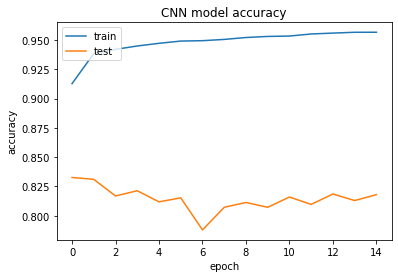

In [20]:
# summarize history for accuracy
plt.plot(hist_cnn.history['accuracy'])
plt.plot(hist_cnn.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

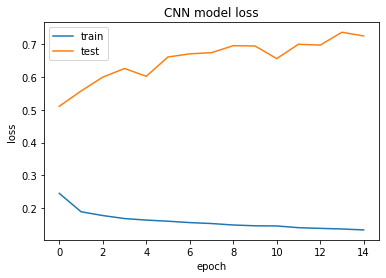

In [21]:
# summarize history for loss
plt.plot(hist_cnn.history['loss'])
plt.plot(hist_cnn.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### CNN with LSTM model

In [22]:
sequence_size = X_train.shape[1]
n_features = 1 
n_subsequences = 4
subsequence_size = int(sequence_size / n_subsequences)

# Reshaping to be (samples, subsequences, sequence, feature)
X_train = X_train.reshape(-1, n_subsequences, subsequence_size, n_features)
X_val = X_val.reshape(-1, n_subsequences, subsequence_size, n_features)

In [23]:
cnn_lstm_model = Sequential([
    TimeDistributed(
        Conv1D(
            filters=8,
            kernel_size=4,
            strides=1,
            padding="same",
            activation="relu"
        ), 
        input_shape=(n_subsequences, subsequence_size, n_features)
    ),
    TimeDistributed(Flatten()),
    LSTM(units=4),
    Dense(
        1,
        activation="sigmoid",
        name="output",
    )
])

optimizer = Adam(lr=0.001)
# Compiling the model
cnn_lstm_model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
cnn_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 4, 540, 8)         40        
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 4320)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 4)                 69200     
_________________________________________________________________
output (Dense)               (None, 1)                 5         
Total params: 69,245
Trainable params: 69,245
Non-trainable params: 0
_________________________________________________________________


In [24]:
train_params = {
    "batch_size": 128,
    "epochs": 15,
    "verbose": 1,
    "validation_data": (X_val, y_val),
}

history_cnn_lstm = cnn_lstm_model.fit(X_train, y_train, **train_params)

Epoch 1/15
648/648 [==============================] - 4s 6ms/step - loss: 0.3698 - accuracy: 0.8462 - val_loss: 0.5775 - val_accuracy: 0.7425
Epoch 2/15
648/648 [==============================] - 3s 5ms/step - loss: 0.2523 - accuracy: 0.9216 - val_loss: 0.5750 - val_accuracy: 0.7685
Epoch 3/15
648/648 [==============================] - 3s 5ms/step - loss: 0.1977 - accuracy: 0.9365 - val_loss: 0.5953 - val_accuracy: 0.7815
Epoch 4/15
648/648 [==============================] - 3s 5ms/step - loss: 0.1728 - accuracy: 0.9458 - val_loss: 0.6145 - val_accuracy: 0.7739
Epoch 5/15
648/648 [==============================] - 3s 5ms/step - loss: 0.1559 - accuracy: 0.9519 - val_loss: 0.6508 - val_accuracy: 0.7865
Epoch 6/15
648/648 [==============================] - 3s 5ms/step - loss: 0.1401 - accuracy: 0.9581 - val_loss: 0.6506 - val_accuracy: 0.7736
Epoch 7/15
648/648 [==============================] - 3s 5ms/step - loss: 0.1272 - accuracy: 0.9608 - val_loss: 0.6822 - val_accuracy: 0.8001
Epoch 

In [25]:
cnn_lstm_model.evaluate(X_val, y_val)

821/821 [==============================] - 1s 2ms/step - loss: 0.6779 - accuracy: 0.7974


[0.6778692007064819, 0.7974408864974976]

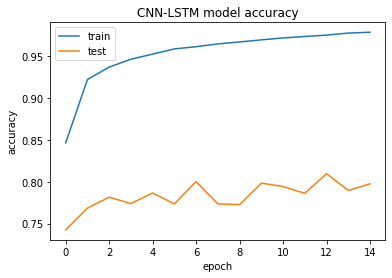

In [26]:
# summarize history for accuracy
plt.plot(history_cnn_lstm.history['accuracy'])
plt.plot(history_cnn_lstm.history['val_accuracy'])
plt.title('CNN-LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

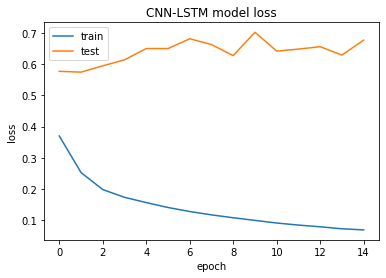

In [27]:
# summarize history for loss
plt.plot(history_cnn_lstm.history['loss'])
plt.plot(history_cnn_lstm.history['val_loss'])
plt.title('CNN-LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()